In [1]:
# Imports

In [2]:
# Supress unnecessary warnings so that the presentation looks clean
import warnings
warnings.filterwarnings("ignore")

import os
from fastai.vision.all import *
import torch
import random
import matplotlib.pyplot as plt 

# Setup

Assuming provided files are present. Installing fastai (may need to restart runtime)

In [3]:
!pip install -qU fastcore fastai

In [4]:
import fastai
fastai.__version__

'2.7.13'

# Load data and put in dataloaders

Fastai makes it relatively easy to get our training data from the dataframe into a format we can use for training.

In [5]:
# Set the seed value all over the place to make this reproducible.
seed  = 42

def seed_value(SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_value(seed)

In [6]:
import os
import pandas as pd

base_dir = '/kaggle/input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin'
image_ids = []
labels = []
file_paths = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        label = os.path.basename(root)
        image_id = os.path.splitext(file)[0]
        file_path = os.path.join(root, file)
        image_ids.append(image_id)
        labels.append('ham' if 'ham' in label else 'spam')
        file_paths.append(".."+ file_path[7:-4])

df = pd.DataFrame({'Image_ID': image_ids, 'Label': labels, 'fn': file_paths})
df


,Image_ID,Label,fn
0,emailimage_5172.2002-01-11.farmer.ham.txt,ham,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_hamE1+E4+assasin/emailimage_5172.2002-01-11.farmer.ham.txt
1,emailimage_0030.1999-12-20.farmer.ham.txt,ham,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_hamE1+E4+assasin/emailimage_0030.1999-12-20.farmer.ham.txt
2,emailimage_ham__4942.2002-01-19.williams.ham,ham,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_hamE1+E4+assasin/emailimage_ham__4942.2002-01-19.williams.ham
3,emailimage_3836.2001-03-16.farmer.ham.txt,ham,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_hamE1+E4+assasin/emailimage_3836.2001-03-16.farmer.ham.txt
4,emailimage_ham__5817.2002-02-02.williams.ham,ham,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_hamE1+E4+assasin/emailimage_ham__5817.2002-02-02.williams.ham
...,...,...,...
7794,emailimage_spam__4411.2005-02-22.GP.spam,spam,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_spamE1+E4+assasin/emailimage_spam__4411.2005-02-22.GP.spam
7795,emailimage_3110.2004-12-08.GP.spam.txt,spam,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_spamE1+E4+assasin/emailimage_3110.2004-12-08.GP.spam.txt
7796,emailscreenshot-spam- (962),spam,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_spamE1+E4+assasin/emailscreenshot-spam- (962)
7797,emailimage_spam__4478.2005-02-27.GP.spam,spam,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_spamE1+E4+assasin/emailimage_spam__4478.2005-02-27.GP.spam


In [7]:
from sklearn.model_selection import train_test_split
train_IDs, test_IDs = train_test_split(df[['Image_ID', 'Label']], test_size=0.2, stratify=df['Label'], random_state=42)

# Save train_IDs and test_IDs to CSV files
train_IDs.to_csv('/kaggle/working/train_IDs.csv', index=False)
test_IDs.to_csv('/kaggle/working/test_IDs.csv', index=False)

train_IDs = pd.read_csv('/kaggle/working/train_IDs.csv')
test_IDs = pd.read_csv('/kaggle/working/test_IDs.csv')

train = df[df["Image_ID"].isin(train_IDs["Image_ID"])]
Test = df[df["Image_ID"].isin(test_IDs["Image_ID"])]

ground_truth_test =  Test[["Image_ID", "Label"]]
ground_truth_train =  train[["Image_ID", "Label"]]
ground_truth_test.to_csv("ground_truth_test.csv")
ground_truth_train.to_csv("ground_truth_train.csv")

print("Train DataFrame shape:", train.shape)
print("Test DataFrame shape:", Test.shape)
train
Test

Train DataFrame shape: (6239, 3)
Test DataFrame shape: (1560, 3)


,Image_ID,Label,fn
1,emailimage_0030.1999-12-20.farmer.ham.txt,ham,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_hamE1+E4+assasin/emailimage_0030.1999-12-20.farmer.ham.txt
4,emailimage_ham__5817.2002-02-02.williams.ham,ham,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_hamE1+E4+assasin/emailimage_ham__5817.2002-02-02.williams.ham
11,emailimage_2830.2000-11-13.farmer.ham.txt,ham,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_hamE1+E4+assasin/emailimage_2830.2000-11-13.farmer.ham.txt
16,emailimage_2425.2000-10-02.farmer.ham.txt,ham,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_hamE1+E4+assasin/emailimage_2425.2000-10-02.farmer.ham.txt
19,emailimage_ham__0938,ham,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_hamE1+E4+assasin/emailimage_ham__0938
...,...,...,...
7782,emailscreenshot-spam- (954),spam,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_spamE1+E4+assasin/emailscreenshot-spam- (954)
7785,emailimage_0585.2004-03-02.GP.spam.txt,spam,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_spamE1+E4+assasin/emailimage_0585.2004-03-02.GP.spam.txt
7787,emailimage_spam_00161,spam,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_spamE1+E4+assasin/emailimage_spam_00161
7794,emailimage_spam__4411.2005-02-22.GP.spam,spam,../input/dataset-for-visual-based-spam-filtering/Final dataset/SpamHamScreenshotsEnron1Enron4SpamAssasin/SpamHamScreenshotsEnron1+Enron4+SpamAssasin/screenshots_spamE1+E4+assasin/emailimage_spam__4411.2005-02-22.GP.spam


In [8]:
ground_truth_train.to_csv("ground_truth_trainnnrrrrrtn.csv")

# class distribution

<Axes: xlabel='Label'>

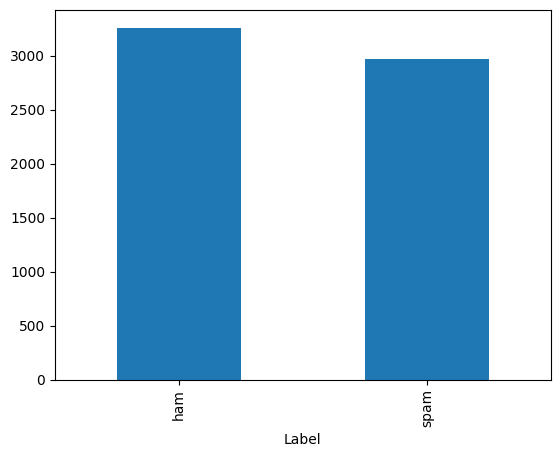

In [9]:
train['Label'].value_counts().plot.bar()

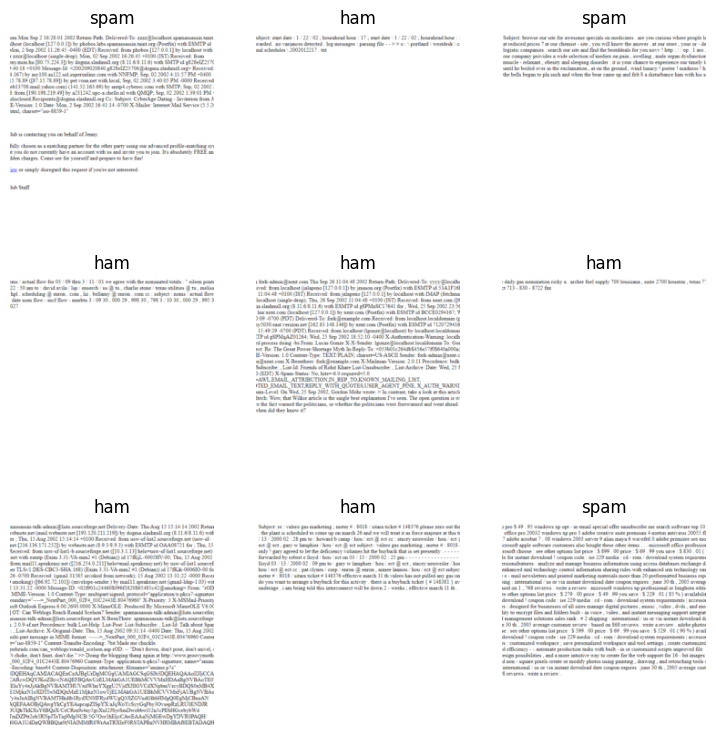

In [10]:
from fastai.vision.all import *
# Define custom data augmentations for training only
augmentations = aug_transforms(
    max_lighting=0.3, p_lighting=0.75,
    max_zoom=1.1,
    max_warp=0.2, p_affine=0.5,
    flip_vert=True, max_rotate=45.0, 
)


dls = ImageDataLoaders.from_df(train,  num_workers=0, bs=64, valid_pct=0.2, fn_col='fn'
                               , label_col='Label', suff='.png', item_tfms=Resize(224))
dls.show_batch()

# Quick Model

No fancy training here - this only took a minute, just enough time for me to organise my previous cells a little :)

ResNet: Residual Networks

Models: resnet18, resnet34, resnet50, resnet101, resnet152
XResNet: Modified ResNet introduced in the fastai library

Models: xresnet18, xresnet34, xresnet50, xresnet101, xresnet152
DenseNet: Densely Connected Convolutional Networks

Models: densenet121, densenet169, densenet201
SqueezeNet: A lightweight neural network architecture

Models: squeezenet1_0, squeezenet1_1
VGG: Visual Geometry Group network

Models: vgg16_bn, vgg19_bn
GoogLeNet: GoogLeNet/Inception

Models: googlenet
ResNext: Aggregated Residual Transformations for Visual Recognition

Models: resnext50_32x4d, resnext101_32x8d
WideResNet: Wide Residual Networks

Models: wrn
MobileNetV2: Efficient convolutional neural network architecture

Models: mobilenet_v2
EfficientNet: Efficient neural network architecture

Models: efficientnet_b0 to efficientnet_b7
SiamFC: Siamese Fully Convolutional Networks

Models: siamese
Unet: U-Net architecture for image segmentation

Models: unet
Vision Transformer Models:

Models:
vit_base_patch16_224, vit_base_patch16_384, vit_base_patch32_384
vit_base_resnet26d_224, vit_base_resnet50d_224
vit_huge_patch16_224, vit_huge_patch32_384
vit_large_patch16_224, vit_large_patch16_384, vit_large_patch32_384
vit_small_patch16_224, vit_small_resnet26d_224, vit_small_resnet50d_s3_224
ConvNeXt Models (pre-trained on ImageNet-22k dataset and fine-tuned on ImageNet-1k dataset):

convnext_tiny_in22k
convnext_small_in22k
convnext_base_in22k
convnext_large_in22k
convnext_xlarge_in22ft1k
convnext_large_in22ft1k
convnext_base_384_in22ft1k
convnext_xlarge_384_in22ft1k
convnext_large_384_in22ft1k

In [11]:
learn = cnn_learner(dls, models.vgg19_bn, metrics=[error_rate, accuracy], pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:30<00:00, 18.9MB/s]


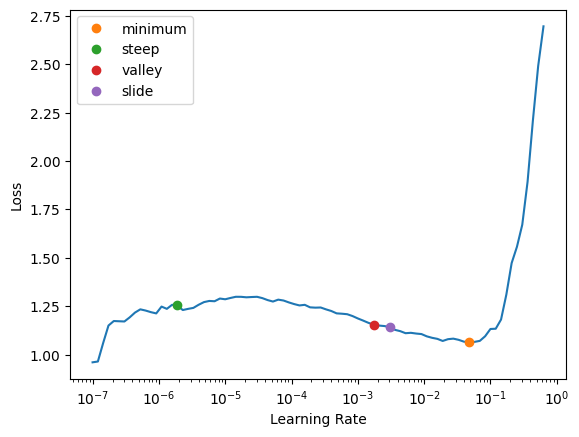

In [12]:
minimum, steep, valley, slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [13]:
learning_rate = slide
epochs = 12

In [14]:
learn.fit(epochs, slice(0.01))
learn.fine_tune(17,0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.733223,0.622588,0.291901,0.708099,02:17
1,0.575924,0.464899,0.222133,0.777867,02:13
2,0.543263,0.415318,0.197273,0.802727,02:13
3,0.486005,0.427961,0.185245,0.814755,02:13
4,0.429065,0.433915,0.191660,0.808340,02:13
5,0.383782,0.336606,0.162791,0.837209,02:13
6,0.355911,0.319072,0.141941,0.858059,02:13
7,0.342321,0.306969,0.133119,0.866881,02:14
8,0.307299,0.315421,0.131516,0.868484,02:13
9,0.299805,0.333893,0.132318,0.867682,02:13


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.249382,0.312539,0.117883,0.882117,02:13


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.346235,0.285582,0.128308,0.871692,02:28
1,0.274890,0.394381,0.165998,0.834002,02:27
2,0.272834,0.453315,0.177225,0.822775,02:29
3,0.253280,0.853118,0.207698,0.792302,02:28
4,0.242370,1.148375,0.391339,0.608661,02:28
5,0.214832,0.722867,0.268645,0.731355,02:28
6,0.171879,0.266362,0.093023,0.906977,02:27
7,0.152272,0.588061,0.149960,0.850040,02:28
8,0.130725,0.282588,0.105052,0.894948,02:27
9,0.102808,0.227434,0.070569,0.929431,02:27


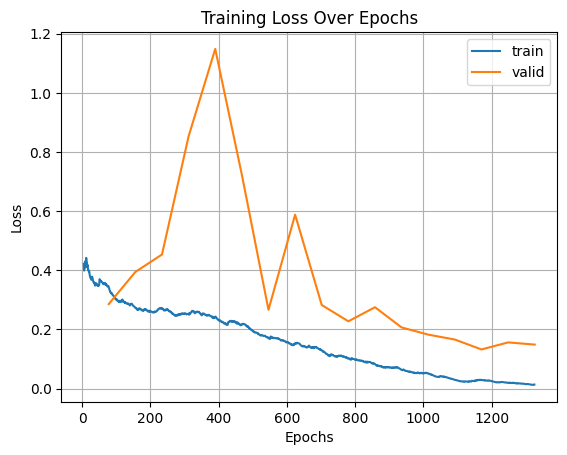

In [15]:
learn.recorder.plot_loss()
plt.xlabel('Epochs')  # X-axis representing the number of epochs
plt.ylabel('Loss')    # Y-axis representing the loss value

# Add a title to the plot
plt.title('Training Loss Over Epochs') 

# Add a grid to the plot
plt.grid(True)
plt.show()

In [16]:
learn.save('vgg19_model')

Path('models/vgg19_model.pth')

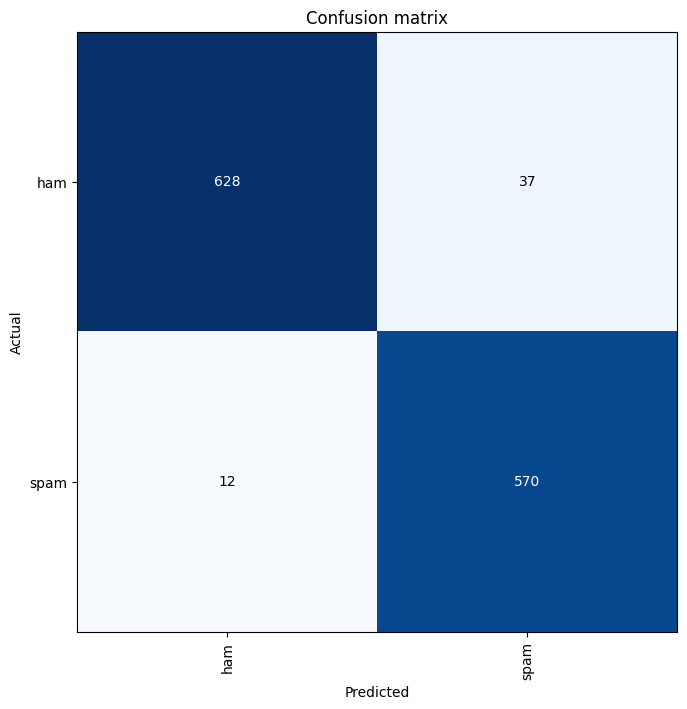

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7, 7), dpi=100)

In [18]:
# from fastai.vision.widgets import *
# #from fastai.vision.all import *
# cleaner = ImageClassifierCleaner(learn)
# misclassified_filenames = cleaner.fns
# print(misclassified_filenames)

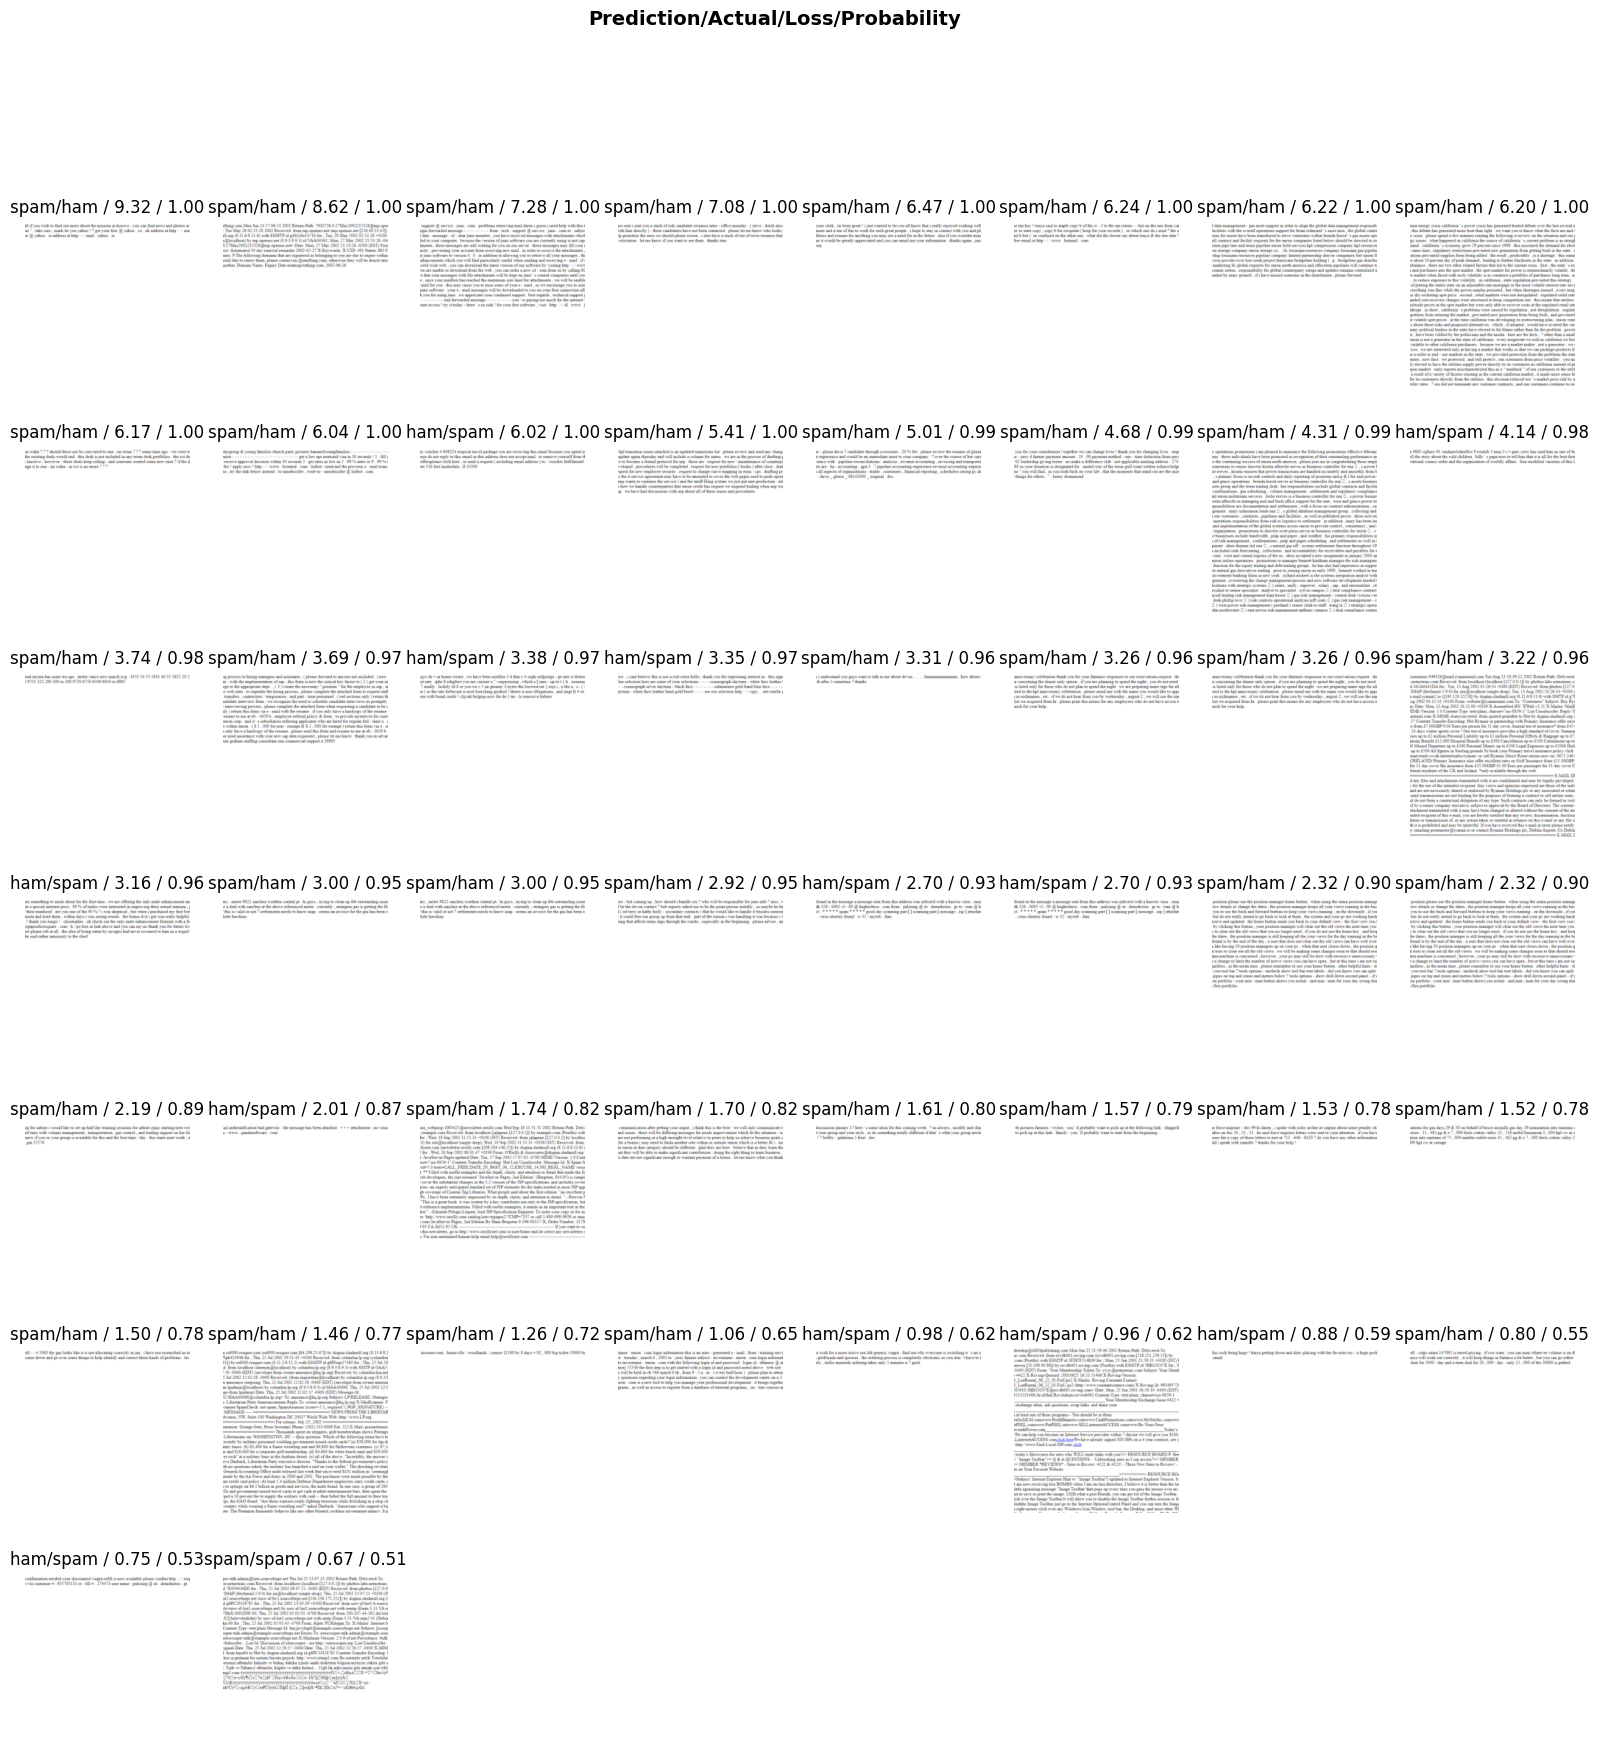

In [19]:
interp.plot_top_losses(50, figsize=(20,20))


# Predicition

In [20]:


Test_preds = learn.get_preds(dl = dls.test_dl(Test)) # Getting the predicted probabilities
train_preds = learn.get_preds(dl = dls.test_dl(train)) # Getting the predicted probabilities

In [21]:
Test_preds_np = Test_preds[0].numpy()[:, 1]
train_preds_np = train_preds[0].numpy()[:, 1]

In [22]:
CNN_Test_Predicition_Prob = Test[['Image_ID','Label']].copy()
CNN_Test_Predicition_Prob['Label'] = Test_preds_np
CNN_Test_Predicition_Prob.to_csv("CNN_Test_Predicition_Prob.csv")

In [23]:
CNN_Train_Predicition_Prob = train[['Image_ID','Label']].copy()
CNN_Train_Predicition_Prob['Label'] = train_preds_np
CNN_Train_Predicition_Prob.to_csv("CNN_Train_Predicition_Prob.csv")

In [24]:
#CNN_Test_Predicition_Prob = pd.DataFrame(Test_preds_np)
#CNN_Train_Predicition_Prob = pd.DataFrame(train_preds_np)


In [25]:
#CNN_Test_Predicition_Prob.to_csv("CNN_Test_Predicition_Prob.csv")
#CNN_Train_Predicition_Prob.to_csv("CNN_Train_Predicition_Prob.csv")

In [26]:

Test_preds_np_Bin = np.where(Test_preds_np > 0.5, 1, 0)
#CNN_Test_Predicition_Bin = pd.DataFrame(Test_preds_np_Bin)

CNN_Test_Predicition_Bin = Test[['Image_ID','Label']].copy()
CNN_Test_Predicition_Bin['Label'] = Test_preds_np_Bin
CNN_Test_Predicition_Bin.to_csv("CNN_Test_Predicition_Bin.csv")

In [27]:

train_preds_np_Bin = np.where(train_preds_np > 0.5, 1, 0)
#CNN_Train_Predicition_Bin = pd.DataFrame(train_preds_np_Bin)
CNN_Train_Predicition_Bin = train[['Image_ID','Label']].copy()
CNN_Train_Predicition_Bin['Label'] = train_preds_np_Bin
CNN_Train_Predicition_Bin.to_csv("CNN_Train_Predicition_Bin.csv")

In [28]:
# Test_preds_np = Test_preds[0].numpy()[:, 0]
# Test_preds_np = np.where(Test_preds_np > 0.5, 1, 0)
# Test_preds_np

# NB_Train_Predicition = train[['text_ID','label']].copy()
# NB_Train_Predicition['label'] = train_pred

In [29]:
# train_preds_np = train_preds[0].numpy()[:, 0]
# train_preds_np = np.where(train_preds_np > 0.5, 1, 0)
# train_preds_np

In [30]:
# pd.DataFrame(Test_preds_np).to_csv("CNN_Test_Predicitions.csv")
# pd.DataFrame(train_preds_np).to_csv("CNN_Train_Predicitions.csv")

